In [27]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [28]:

economy_df = pd.read_csv('/content/drive/MyDrive/Flight_Dataset/economy.csv')
economy_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [77]:

economy_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 206770 entries, 0 to 206773
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   from             206770 non-null  int64  
 1   to               206770 non-null  int64  
 2   price            206770 non-null  float64
 3   day              206770 non-null  int32  
 4   month            206770 non-null  int32  
 5   weekday          206770 non-null  int32  
 6   duration_mins    206770 non-null  float64
 7   dep_hour         206770 non-null  int64  
 8   dep_min          206770 non-null  int64  
 9   arr_hour         206770 non-null  int64  
 10  arr_min          206770 non-null  int64  
 11  airline_encoded  206770 non-null  int64  
dtypes: float64(2), int32(3), int64(7)
memory usage: 18.1 MB


In [76]:
economy_df.isnull().sum()

,0
from,0
to,0
price,0
day,0
month,0
weekday,0
duration_mins,0
dep_hour,0
dep_min,0
arr_hour,0


In [31]:
# Parse the 'date' column and extract day, month, weekday
def clean_and_parse_date(date_str):
    try:
        if pd.isnull(date_str) or not isinstance(date_str, str):
            return pd.NaT
        date_str = date_str.strip().replace(',', '').replace('.', '/')
        return parser.parse(date_str, dayfirst=True)
    except:
        return pd.NaT

economy_df['date'] = economy_df['date'].apply(clean_and_parse_date)
economy_df['day'] = economy_df['date'].dt.day
economy_df['month'] = economy_df['date'].dt.month
economy_df['weekday'] = economy_df['date'].dt.weekday
economy_df[['date', 'day', 'month', 'weekday']].head()

,date,day,month,weekday
0,2022-02-11,11,2,4
1,2022-02-11,11,2,4
2,2022-02-11,11,2,4
3,2022-02-11,11,2,4
4,2022-02-11,11,2,4


In [32]:
# Convert 'time_taken' into total minutes only
def convert_time_taken(x):
    try:
        if 'h' in x and 'm' in x:
            h, m = x.split('h')
            h = int(h.strip())
            m = int(m.replace('m', '').strip())
        elif 'h' in x:
            h = int(x.replace('h', '').strip())
            m = 0
        elif 'm' in x:
            h = 0
            m = int(x.replace('m', '').strip())
        else:
            h = 0
            m = 0
        return h*60 + m
    except:
        return np.nan

economy_df['duration_mins'] = economy_df['time_taken'].astype(str).apply(convert_time_taken)
economy_df[['time_taken', 'duration_mins']].head()

,time_taken,duration_mins
0,02h 10m,130.0
1,02h 20m,140.0
2,02h 10m,130.0
3,02h 15m,135.0
4,02h 20m,140.0


In [33]:
economy_df

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,day,month,weekday,duration_mins
0,2022-02-11,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953.0,11,2,4,130.0
1,2022-02-11,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953.0,11,2,4,140.0
2,2022-02-11,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956.0,11,2,4,130.0
3,2022-02-11,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955.0,11,2,4,135.0
4,2022-02-11,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955.0,11,2,4,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,UK,832,07:05,Chennai,13h 50m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Hyderabad,7697.0,31,3,3,830.0
206770,2022-03-31,Vistara,UK,832,07:05,Chennai,13h 50m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Hyderabad,7709.0,31,3,3,830.0
206771,2022-03-31,Vistara,UK,826,12:30,Chennai,20h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,09:05,Hyderabad,8640.0,31,3,3,1235.0
206772,2022-03-31,Vistara,UK,822,09:45,Chennai,23h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,09:05,Hyderabad,8640.0,31,3,3,1400.0


In [34]:
economy_df.drop(['stop'], axis=1, inplace=True)

In [35]:
economy_df.drop(['ch_code'], axis=1, inplace=True)

In [36]:
economy_df

,date,airline,num_code,dep_time,from,time_taken,arr_time,to,price,day,month,weekday,duration_mins
0,2022-02-11,SpiceJet,8709,18:55,Delhi,02h 10m,21:05,Mumbai,5953.0,11,2,4,130.0
1,2022-02-11,SpiceJet,8157,06:20,Delhi,02h 20m,08:40,Mumbai,5953.0,11,2,4,140.0
2,2022-02-11,AirAsia,764,04:25,Delhi,02h 10m,06:35,Mumbai,5956.0,11,2,4,130.0
3,2022-02-11,Vistara,995,10:20,Delhi,02h 15m,12:35,Mumbai,5955.0,11,2,4,135.0
4,2022-02-11,Vistara,963,08:50,Delhi,02h 20m,11:10,Mumbai,5955.0,11,2,4,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,832,07:05,Chennai,13h 50m,20:55,Hyderabad,7697.0,31,3,3,830.0
206770,2022-03-31,Vistara,832,07:05,Chennai,13h 50m,20:55,Hyderabad,7709.0,31,3,3,830.0
206771,2022-03-31,Vistara,826,12:30,Chennai,20h 35m,09:05,Hyderabad,8640.0,31,3,3,1235.0
206772,2022-03-31,Vistara,822,09:45,Chennai,23h 20m,09:05,Hyderabad,8640.0,31,3,3,1400.0


In [37]:
economy_df.isnull().sum()

,0
date,0
airline,0
num_code,0
dep_time,0
from,0
time_taken,0
arr_time,0
to,0
price,0
day,0


In [38]:
economy_df.dropna()

,date,airline,num_code,dep_time,from,time_taken,arr_time,to,price,day,month,weekday,duration_mins
0,2022-02-11,SpiceJet,8709,18:55,Delhi,02h 10m,21:05,Mumbai,5953.0,11,2,4,130.0
1,2022-02-11,SpiceJet,8157,06:20,Delhi,02h 20m,08:40,Mumbai,5953.0,11,2,4,140.0
2,2022-02-11,AirAsia,764,04:25,Delhi,02h 10m,06:35,Mumbai,5956.0,11,2,4,130.0
3,2022-02-11,Vistara,995,10:20,Delhi,02h 15m,12:35,Mumbai,5955.0,11,2,4,135.0
4,2022-02-11,Vistara,963,08:50,Delhi,02h 20m,11:10,Mumbai,5955.0,11,2,4,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,832,07:05,Chennai,13h 50m,20:55,Hyderabad,7697.0,31,3,3,830.0
206770,2022-03-31,Vistara,832,07:05,Chennai,13h 50m,20:55,Hyderabad,7709.0,31,3,3,830.0
206771,2022-03-31,Vistara,826,12:30,Chennai,20h 35m,09:05,Hyderabad,8640.0,31,3,3,1235.0
206772,2022-03-31,Vistara,822,09:45,Chennai,23h 20m,09:05,Hyderabad,8640.0,31,3,3,1400.0


In [39]:
edf=economy_df

In [40]:
edf.isnull().sum()

,0
date,0
airline,0
num_code,0
dep_time,0
from,0
time_taken,0
arr_time,0
to,0
price,0
day,0


In [41]:
edf.dropna(inplace=True)

In [42]:
edf.isnull().sum()

,0
date,0
airline,0
num_code,0
dep_time,0
from,0
time_taken,0
arr_time,0
to,0
price,0
day,0


In [43]:
edf.drop(['num_code'], axis=1, inplace=True)

In [44]:
edf

,date,airline,dep_time,from,time_taken,arr_time,to,price,day,month,weekday,duration_mins
0,2022-02-11,SpiceJet,18:55,Delhi,02h 10m,21:05,Mumbai,5953.0,11,2,4,130.0
1,2022-02-11,SpiceJet,06:20,Delhi,02h 20m,08:40,Mumbai,5953.0,11,2,4,140.0
2,2022-02-11,AirAsia,04:25,Delhi,02h 10m,06:35,Mumbai,5956.0,11,2,4,130.0
3,2022-02-11,Vistara,10:20,Delhi,02h 15m,12:35,Mumbai,5955.0,11,2,4,135.0
4,2022-02-11,Vistara,08:50,Delhi,02h 20m,11:10,Mumbai,5955.0,11,2,4,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,07:05,Chennai,13h 50m,20:55,Hyderabad,7697.0,31,3,3,830.0
206770,2022-03-31,Vistara,07:05,Chennai,13h 50m,20:55,Hyderabad,7709.0,31,3,3,830.0
206771,2022-03-31,Vistara,12:30,Chennai,20h 35m,09:05,Hyderabad,8640.0,31,3,3,1235.0
206772,2022-03-31,Vistara,09:45,Chennai,23h 20m,09:05,Hyderabad,8640.0,31,3,3,1400.0


In [45]:
edf.dtypes

,0
date,datetime64[ns]
airline,object
dep_time,object
from,object
time_taken,object
arr_time,object
to,object
price,float64
day,int32
month,int32


In [46]:
edd=edf

In [47]:
# Function to extract hour and minute from time strings like "10:30" or "22:45"
def extract_hour_minute(time_str):
    try:
        if isinstance(time_str, str) and ':' in time_str:
            hour, minute = map(int, time_str.strip().split(':'))
            return hour, minute
    except:
        return np.nan, np.nan
    return np.nan, np.nan


edd['dep_hour'], edd['dep_min'] = zip(*edd['dep_time'].apply(extract_hour_minute))


edd['arr_hour'], edd['arr_min'] = zip(*edd['arr_time'].apply(extract_hour_minute))




In [48]:
edd

,date,airline,dep_time,from,time_taken,arr_time,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min
0,2022-02-11,SpiceJet,18:55,Delhi,02h 10m,21:05,Mumbai,5953.0,11,2,4,130.0,18,55,21,5
1,2022-02-11,SpiceJet,06:20,Delhi,02h 20m,08:40,Mumbai,5953.0,11,2,4,140.0,6,20,8,40
2,2022-02-11,AirAsia,04:25,Delhi,02h 10m,06:35,Mumbai,5956.0,11,2,4,130.0,4,25,6,35
3,2022-02-11,Vistara,10:20,Delhi,02h 15m,12:35,Mumbai,5955.0,11,2,4,135.0,10,20,12,35
4,2022-02-11,Vistara,08:50,Delhi,02h 20m,11:10,Mumbai,5955.0,11,2,4,140.0,8,50,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,07:05,Chennai,13h 50m,20:55,Hyderabad,7697.0,31,3,3,830.0,7,5,20,55
206770,2022-03-31,Vistara,07:05,Chennai,13h 50m,20:55,Hyderabad,7709.0,31,3,3,830.0,7,5,20,55
206771,2022-03-31,Vistara,12:30,Chennai,20h 35m,09:05,Hyderabad,8640.0,31,3,3,1235.0,12,30,9,5
206772,2022-03-31,Vistara,09:45,Chennai,23h 20m,09:05,Hyderabad,8640.0,31,3,3,1400.0,9,45,9,5


In [49]:

# Drop the dep_time and arr_time (object datatype)
economy_df.drop(['dep_time', 'arr_time'], axis=1, inplace=True)


economy_df.head()

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min
0,2022-02-11,SpiceJet,Delhi,02h 10m,Mumbai,5953.0,11,2,4,130.0,18,55,21,5
1,2022-02-11,SpiceJet,Delhi,02h 20m,Mumbai,5953.0,11,2,4,140.0,6,20,8,40
2,2022-02-11,AirAsia,Delhi,02h 10m,Mumbai,5956.0,11,2,4,130.0,4,25,6,35
3,2022-02-11,Vistara,Delhi,02h 15m,Mumbai,5955.0,11,2,4,135.0,10,20,12,35
4,2022-02-11,Vistara,Delhi,02h 20m,Mumbai,5955.0,11,2,4,140.0,8,50,11,10


In [50]:
edd

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min
0,2022-02-11,SpiceJet,Delhi,02h 10m,Mumbai,5953.0,11,2,4,130.0,18,55,21,5
1,2022-02-11,SpiceJet,Delhi,02h 20m,Mumbai,5953.0,11,2,4,140.0,6,20,8,40
2,2022-02-11,AirAsia,Delhi,02h 10m,Mumbai,5956.0,11,2,4,130.0,4,25,6,35
3,2022-02-11,Vistara,Delhi,02h 15m,Mumbai,5955.0,11,2,4,135.0,10,20,12,35
4,2022-02-11,Vistara,Delhi,02h 20m,Mumbai,5955.0,11,2,4,140.0,8,50,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,Chennai,13h 50m,Hyderabad,7697.0,31,3,3,830.0,7,5,20,55
206770,2022-03-31,Vistara,Chennai,13h 50m,Hyderabad,7709.0,31,3,3,830.0,7,5,20,55
206771,2022-03-31,Vistara,Chennai,20h 35m,Hyderabad,8640.0,31,3,3,1235.0,12,30,9,5
206772,2022-03-31,Vistara,Chennai,23h 20m,Hyderabad,8640.0,31,3,3,1400.0,9,45,9,5


In [51]:
edd_copy=edd

In [52]:
#Label Encoder pkl for 'from' and 'to' city name columns
from sklearn.preprocessing import LabelEncoder
import joblib

city_le = LabelEncoder()


all_cities = pd.concat([edd_copy['from'], edd_copy['to']]).unique()
city_le.fit(all_cities)

edd_copy['from'] = city_le.transform(edd_copy['from'])
edd_copy['to'] = city_le.transform(edd_copy['to'])


joblib.dump(city_le, 'city_label_encoder.pkl')



['city_label_encoder.pkl']

In [53]:
edd_copy

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min
0,2022-02-11,SpiceJet,2,02h 10m,5,5953.0,11,2,4,130.0,18,55,21,5
1,2022-02-11,SpiceJet,2,02h 20m,5,5953.0,11,2,4,140.0,6,20,8,40
2,2022-02-11,AirAsia,2,02h 10m,5,5956.0,11,2,4,130.0,4,25,6,35
3,2022-02-11,Vistara,2,02h 15m,5,5955.0,11,2,4,135.0,10,20,12,35
4,2022-02-11,Vistara,2,02h 20m,5,5955.0,11,2,4,140.0,8,50,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,1,13h 50m,3,7697.0,31,3,3,830.0,7,5,20,55
206770,2022-03-31,Vistara,1,13h 50m,3,7709.0,31,3,3,830.0,7,5,20,55
206771,2022-03-31,Vistara,1,20h 35m,3,8640.0,31,3,3,1235.0,12,30,9,5
206772,2022-03-31,Vistara,1,23h 20m,3,8640.0,31,3,3,1400.0,9,45,9,5


In [54]:
edd_copy.isnull().sum()

,0
date,0
airline,0
from,0
time_taken,0
to,0
price,0
day,0
month,0
weekday,0
duration_mins,0


In [56]:
edd_copy

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,...,arr_hour,arr_min,airline_Air India,airline_AirAsia,airline_GO FIRST,airline_Indigo,airline_SpiceJet,airline_StarAir,airline_Trujet,airline_Vistara
0,2022-02-11,SpiceJet,2,02h 10m,5,5953.0,11,2,4,130.0,...,21,5,False,False,False,False,True,False,False,False
1,2022-02-11,SpiceJet,2,02h 20m,5,5953.0,11,2,4,140.0,...,8,40,False,False,False,False,True,False,False,False
2,2022-02-11,AirAsia,2,02h 10m,5,5956.0,11,2,4,130.0,...,6,35,False,True,False,False,False,False,False,False
3,2022-02-11,Vistara,2,02h 15m,5,5955.0,11,2,4,135.0,...,12,35,False,False,False,False,False,False,False,True
4,2022-02-11,Vistara,2,02h 20m,5,5955.0,11,2,4,140.0,...,11,10,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,1,13h 50m,3,7697.0,31,3,3,830.0,...,20,55,False,False,False,False,False,False,False,True
206770,2022-03-31,Vistara,1,13h 50m,3,7709.0,31,3,3,830.0,...,20,55,False,False,False,False,False,False,False,True
206771,2022-03-31,Vistara,1,20h 35m,3,8640.0,31,3,3,1235.0,...,9,5,False,False,False,False,False,False,False,True
206772,2022-03-31,Vistara,1,23h 20m,3,8640.0,31,3,3,1400.0,...,9,5,False,False,False,False,False,False,False,True


In [57]:
eca=edd

In [58]:
eca

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min
0,2022-02-11,SpiceJet,2,02h 10m,5,5953.0,11,2,4,130.0,18,55,21,5
1,2022-02-11,SpiceJet,2,02h 20m,5,5953.0,11,2,4,140.0,6,20,8,40
2,2022-02-11,AirAsia,2,02h 10m,5,5956.0,11,2,4,130.0,4,25,6,35
3,2022-02-11,Vistara,2,02h 15m,5,5955.0,11,2,4,135.0,10,20,12,35
4,2022-02-11,Vistara,2,02h 20m,5,5955.0,11,2,4,140.0,8,50,11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,1,13h 50m,3,7697.0,31,3,3,830.0,7,5,20,55
206770,2022-03-31,Vistara,1,13h 50m,3,7709.0,31,3,3,830.0,7,5,20,55
206771,2022-03-31,Vistara,1,20h 35m,3,8640.0,31,3,3,1235.0,12,30,9,5
206772,2022-03-31,Vistara,1,23h 20m,3,8640.0,31,3,3,1400.0,9,45,9,5


In [59]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Step 1: Initialize the LabelEncoder
airline_le = LabelEncoder()

# Step 2: Fit and transform the airline column
eca['airline_encoded'] = airline_le.fit_transform(eca['airline'])

# Step 3: Save the fitted encoder for future use in interface
joblib.dump(airline_le, 'airline_label_encoder.pkl')




['airline_label_encoder.pkl']

In [60]:
eca

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min,airline_encoded
0,2022-02-11,SpiceJet,2,02h 10m,5,5953.0,11,2,4,130.0,18,55,21,5,4
1,2022-02-11,SpiceJet,2,02h 20m,5,5953.0,11,2,4,140.0,6,20,8,40,4
2,2022-02-11,AirAsia,2,02h 10m,5,5956.0,11,2,4,130.0,4,25,6,35,1
3,2022-02-11,Vistara,2,02h 15m,5,5955.0,11,2,4,135.0,10,20,12,35,7
4,2022-02-11,Vistara,2,02h 20m,5,5955.0,11,2,4,140.0,8,50,11,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,1,13h 50m,3,7697.0,31,3,3,830.0,7,5,20,55,7
206770,2022-03-31,Vistara,1,13h 50m,3,7709.0,31,3,3,830.0,7,5,20,55,7
206771,2022-03-31,Vistara,1,20h 35m,3,8640.0,31,3,3,1235.0,12,30,9,5,7
206772,2022-03-31,Vistara,1,23h 20m,3,8640.0,31,3,3,1400.0,9,45,9,5,7


In [61]:
eca

,date,airline,from,time_taken,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min,airline_encoded
0,2022-02-11,SpiceJet,2,02h 10m,5,5953.0,11,2,4,130.0,18,55,21,5,4
1,2022-02-11,SpiceJet,2,02h 20m,5,5953.0,11,2,4,140.0,6,20,8,40,4
2,2022-02-11,AirAsia,2,02h 10m,5,5956.0,11,2,4,130.0,4,25,6,35,1
3,2022-02-11,Vistara,2,02h 15m,5,5955.0,11,2,4,135.0,10,20,12,35,7
4,2022-02-11,Vistara,2,02h 20m,5,5955.0,11,2,4,140.0,8,50,11,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,1,13h 50m,3,7697.0,31,3,3,830.0,7,5,20,55,7
206770,2022-03-31,Vistara,1,13h 50m,3,7709.0,31,3,3,830.0,7,5,20,55,7
206771,2022-03-31,Vistara,1,20h 35m,3,8640.0,31,3,3,1235.0,12,30,9,5,7
206772,2022-03-31,Vistara,1,23h 20m,3,8640.0,31,3,3,1400.0,9,45,9,5,7


In [62]:
eca.drop(['date', 'time_taken'], axis=1, inplace=True)

In [63]:
eca

,airline,from,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min,airline_encoded
0,SpiceJet,2,5,5953.0,11,2,4,130.0,18,55,21,5,4
1,SpiceJet,2,5,5953.0,11,2,4,140.0,6,20,8,40,4
2,AirAsia,2,5,5956.0,11,2,4,130.0,4,25,6,35,1
3,Vistara,2,5,5955.0,11,2,4,135.0,10,20,12,35,7
4,Vistara,2,5,5955.0,11,2,4,140.0,8,50,11,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206769,Vistara,1,3,7697.0,31,3,3,830.0,7,5,20,55,7
206770,Vistara,1,3,7709.0,31,3,3,830.0,7,5,20,55,7
206771,Vistara,1,3,8640.0,31,3,3,1235.0,12,30,9,5,7
206772,Vistara,1,3,8640.0,31,3,3,1400.0,9,45,9,5,7


In [64]:
eca.dtypes

,0
airline,object
from,int64
to,int64
price,float64
day,int32
month,int32
weekday,int32
duration_mins,float64
dep_hour,int64
dep_min,int64


In [65]:
eca.drop(['airline'],inplace=True,axis=1)

In [66]:
eca

,from,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min,airline_encoded
0,2,5,5953.0,11,2,4,130.0,18,55,21,5,4
1,2,5,5953.0,11,2,4,140.0,6,20,8,40,4
2,2,5,5956.0,11,2,4,130.0,4,25,6,35,1
3,2,5,5955.0,11,2,4,135.0,10,20,12,35,7
4,2,5,5955.0,11,2,4,140.0,8,50,11,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...
206769,1,3,7697.0,31,3,3,830.0,7,5,20,55,7
206770,1,3,7709.0,31,3,3,830.0,7,5,20,55,7
206771,1,3,8640.0,31,3,3,1235.0,12,30,9,5,7
206772,1,3,8640.0,31,3,3,1400.0,9,45,9,5,7


<ipython-input-75-bad644dc36dc>:11: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


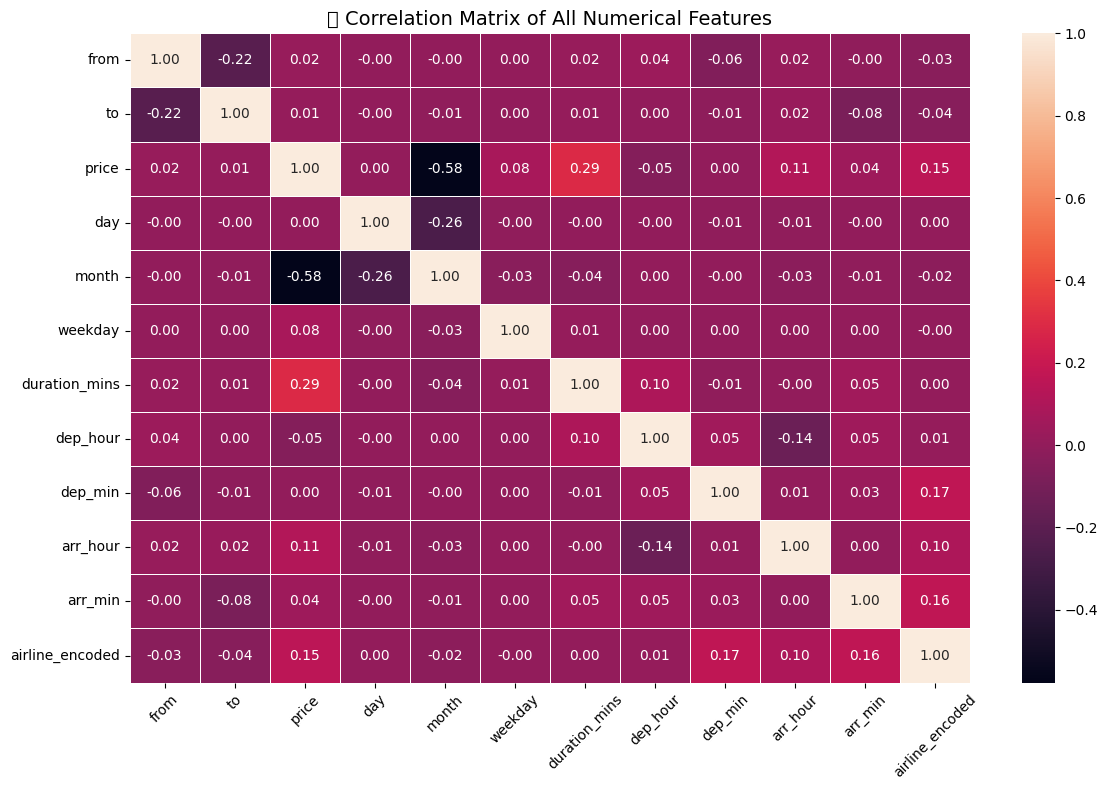

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = eca.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title("🔗 Correlation Matrix of All Numerical Features", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [68]:

eca.to_csv('processed_flight_data.csv', index=False)


from google.colab import files
files.download('processed_flight_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
eta=pd.read_csv('/content/processed_flight_data.csv')

In [70]:
eta

,from,to,price,day,month,weekday,duration_mins,dep_hour,dep_min,arr_hour,arr_min,airline_encoded
0,2,5,5953.0,11,2,4,130.0,18,55,21,5,4
1,2,5,5953.0,11,2,4,140.0,6,20,8,40,4
2,2,5,5956.0,11,2,4,130.0,4,25,6,35,1
3,2,5,5955.0,11,2,4,135.0,10,20,12,35,7
4,2,5,5955.0,11,2,4,140.0,8,50,11,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...
206765,1,3,7697.0,31,3,3,830.0,7,5,20,55,7
206766,1,3,7709.0,31,3,3,830.0,7,5,20,55,7
206767,1,3,8640.0,31,3,3,1235.0,12,30,9,5,7
206768,1,3,8640.0,31,3,3,1400.0,9,45,9,5,7


In [71]:

from sklearn.model_selection import train_test_split


y = eta['price']
X = eta.drop(['price'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


rf_pred = rf_model.predict(X_test)
rf_train_pred = rf_model.predict(X_train)


print("Random Forest Results")
print("Training R² Score:", r2_score(y_train, rf_train_pred))
print("Testing R² Score:", r2_score(y_test, rf_pred))

print("Training Accuracy (%):", round(r2_score(y_train, rf_train_pred) * 100, 2))
print("Testing Accuracy (%):", round(r2_score(y_test, rf_pred) * 100, 2))

print("MAE (Mean Absolute Error):", mean_absolute_error(y_test, rf_pred))
print("RMSE (Root Mean Squared Error):", mean_squared_error(y_test, rf_pred))




Random Forest Results
Training R² Score: 0.9811835605156726
Testing R² Score: 0.8813855468344876
Training Accuracy (%): 98.12
Testing Accuracy (%): 88.14
MAE (Mean Absolute Error): 564.3439582390064
RMSE (Root Mean Squared Error): 1673389.772118432


In [73]:
rf_model

RandomForestRegressor(random_state=42)

In [ ]:
#XGBoost Regressor
from xgboost import XGBRegressor


xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)


xgb_pred = xgb_model.predict(X_test)
print("XGBoost Results")
print("R² Score:", r2_score(y_test, xgb_pred))
print("MAE:", mean_absolute_error(y_test, xgb_pred))
print("RMSE:", mean_squared_error(y_test, xgb_pred))


XGBoost Results
R² Score: 0.8076093756284022
MAE: 1006.1484801215902
RMSE: 2714209.7314707143


In [ ]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor


gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)


gb_pred = gb_model.predict(X_test)
print("Gradient Boosting Results")
print("R² Score:", r2_score(y_test, gb_pred))
print("MAE:", mean_absolute_error(y_test, gb_pred))
print("RMSE:", mean_squared_error(y_test, gb_pred
                                  ))


Gradient Boosting Results
R² Score: 0.6751185827694112
MAE: 1422.6325772744815
RMSE: 4583364.221107226


In [74]:
#Done